# Cancer Detection Histopathology Using Deep Learning

This project is will take Whole Slide Imaging (WSI) patches of tissue in combination with Convolutional Neural Networks to classify metastatic cancer.

---

This project derives from the Kaggle competition with the name Histopathologic Cancer Detection, found here: https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview

You can find this project at the github repo: https://github.com/chill0121/Kaggle_Projects/tree/main/Cancer_Detection_Histopathology

## Table of Contents <a name="toc"></a>

---

- 1.[**Data Source Information**](#datasource)
  - 1.1. [Dataset Information](#data)
  - 1.2. [Kaggle Information](#kaggle)
- 2.[**Setup**](#setup)
  - 2.1. [Environment Details for Reproducility](#env)
  - 2.2. [Importing the Data](#dataimport)
- 3.[**Data Preprocessing**](#datapre)
  - 3.1. [First Looks](#firstlook)
  - 3.2. [Pixel Normalization](#norm)
- 4.[**Exploratory Data Analysis (EDA)**](#eda)
- 5.[**Models**](#models)
  - 5.1. [Baseline Models](#baseline)
  - 5.2. [Model Helper Functions](#helper)
  - 5.3. [Deep Learning Models](#deep)
- 6.[**Results**](#results)
- 7.[**Conclusion - Kaggle Submission Test Set**](#conclusion)
  - 7.1. [Possible Areas for Improvement](#improvements)

- [**Appendix A - Online References**](#appendixa)

## 1. Data Source Information <a name="datasource"></a>

---


### 1.1. Data Information: <a name="data"></a>

Color images (96 x 96 pixels) extracted from histopathologic scans of lymph node sections. These 96 x 96 images are patches of a whole slide image.

The data in this project is an altered/reduced version of PatchCamelyon (PCam). Each image is annotated with a binary label indicating presence of metastatic tissue. This dataset was first introduced in this paper: https://arxiv.org/abs/1806.03962v1

**An important distinction about this Kaggle competition:**

"In this dataset, you are provided with a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. You are predicting the labels for the images in the test folder. **A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue.** Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image."

The original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates. We have otherwise maintained the same data and splits as the PCam benchmark."

**Data Info:**
- 277,485 Slide Image Patches
    - Images: 96 x 96 x 3

### 1.2. Kaggle Information: <a name="kaggle"></a>

#### Description:

In this competition, you must create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates).

#### Evaluation:

Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

#### Citation: 

Will Cukierski. (2018). Histopathologic Cancer Detection. Kaggle. https://kaggle.com/competitions/histopathologic-cancer-detection

###### [Back to Table of Contents](#toc)

## 2. Setup <a name="setup"></a>

---

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

import sklearn
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score,classification_report, confusion_matrix, ConfusionMatrixDisplay, auc, roc_curve, RocCurveDisplay, roc_auc_score

import tensorflow as tf
import torch

###### [Back to Table of Contents](#toc)

### 2.1. Environment Information for Reproducibility: <a name="env"></a>

In [2]:
print(f"Python version: {sys.version}")

packages = [pd, np, sns, sklearn, tf, torch]
for package in packages:
    print(f"{str(package).partition('from')[0]} using version: {package.__version__}")

Python version: 3.11.9 (main, Apr  2 2024, 08:25:04) [Clang 15.0.0 (clang-1500.3.9.4)]
<module 'pandas'  using version: 2.1.4
<module 'numpy'  using version: 1.26.4
<module 'seaborn'  using version: 0.13.2
<module 'sklearn'  using version: 1.3.2
<module 'tensorflow'  using version: 2.16.2
<module 'torch'  using version: 2.2.2


###### [Back to Table of Contents](#toc)

### 2.2. Importing the Data: <a name="dataimport"></a>

In [3]:
# Set directories
current_wdir = os.getcwd()
data_folder = current_wdir + '/Data/'

In [4]:
train_labels = pd.read_csv(data_folder + 'train_labels.csv')
train_labels

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0


Now, we should ensure there aren't any slide patches with completely missing data.

In [5]:
train_labels.isna().sum()

id       0
label    0
dtype: int64

Here we can also check to make sure there are no duplicate image ids.

In [6]:
print('Duplicates Found:', train_labels.duplicated().sum())

Duplicates Found: 0


In [7]:
n_samples = 10000
rand_seed = 11

# Randomly sample all training images.
train_ids_sampled = pd.concat([train_labels[train_labels.label == 0].sample(n_samples, replace = False, random_state = rand_seed),
                               train_labels[train_labels.label == 1].sample(n_samples, replace = False, random_state = rand_seed)])

# Subset validation set from training and separate X, y.
X_train, X_val, y_train, y_val = train_test_split(train_ids_sampled.id, train_ids_sampled.label, 
                                                  train_size = 0.8, shuffle = True, random_state = rand_seed, stratify = train_ids_sampled.label)

print(f'Training Set Size: {len(X_train):,}')
print(f'Validation Set Size: {len(X_val):,}')

Training Set Size: 16,000
Validation Set Size: 4,000


In [8]:
def image_import(file_list, folder_name):
    '''
    Takes a list of image filenames and loads the images into a dictionary with the same filename(*).
    
    Parameters:
        file_list: List of filenames in the form ['name.extension', ...]
        folder_name: String of folder name within ./Data/ to import.
    Returns:
        image_array: ndarray of images.
        id_array: ndarray of image ids.
    '''
    id_array = np.empty(len(file_list), dtype = object)
    image_array = np.zeros((len(file_list), 96, 96, 3)) # 4D Array with shape (n_images, height, width, channels)
    print(f'Importing {len(file_list):,} images:')
    for i, id in enumerate(file_list):
        if folder_name == 'test':
            img = Image.open(f'./Data/{folder_name}/{id}')
        else:
            img = Image.open(f'./Data/{folder_name}/{id}.tif')
        id_array[i] = id
        image_array[i] = np.asarray(img)
        if (i+1) % 5_000 == 0:
            print(f"{' ':<2}... # {i+1:,}")

    print('Completed!')
    return image_array, id_array 

In [9]:
# files_train = os.listdir('./Data/train') # Only use to import all ~200,000 images!
files_test = os.listdir('./Data/test') # Contains ~60,000 images!

X_train, train_ids = image_import(X_train, 'train')
X_val, val_ids = image_import(X_val, 'train')
#test_images, test_ids = image_import(files_test, 'test')

Importing 16,000 images:
  ... # 5,000
  ... # 10,000
  ... # 15,000
Completed!
Importing 4,000 images:
Completed!


###### [Back to Table of Contents](#toc)

## 3. Data Preprocessing <a name="datapre"></a>

---

### 3.1. First Looks: <a name="firstlook"></a>

First we should take a look at a few images to get an idea what the patches of the whole slide images look like.

Image Shape:
 (96, 96, 3)


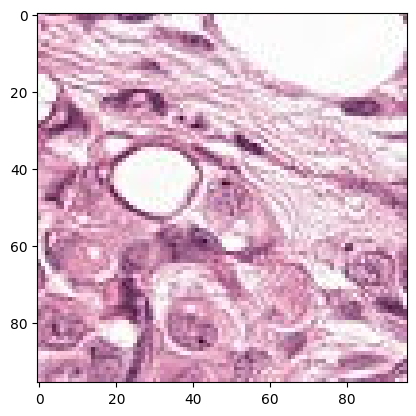

In [10]:
print('Image Shape:\n', X_train[0].shape)
fig, ax = plt.subplots()
ax.imshow(Image.fromarray(X_train[0].astype(np.uint8))) # PIL requires uint8.
plt.show()

###### [Back to Table of Contents](#toc)

### 3.2. Pixel Normalization: <a name="norm"></a>

The models will perform better and more efficiently if we normalize the pixel values to range from 0-1 instead of 0-255 as it is now.

A function to perform this as needed will be used.

In [11]:
def normalize_pixels(array):
    return array / 255

Flatten and stack (using reshape) array.

In [12]:
def flat_stack(X_array):
    return X_array.flatten().reshape(len(X_array), 96*96*3)

###### [Back to Table of Contents](#toc)

## 4. Exploratory Data Analysis (EDA) <a name="eda"></a>

---

To keep all future plots clear and consistent, a color map dictionary will map the classes to a color. 

I choose a color to indicate cancerous that will be distinct against the pinks and purples of the slides.

In [13]:
# Build custom color map for consistent label visualization.
class_cmap = {'Not Cancerous' : 'black',
              'Cancerous' : '#32a87b'}

In [14]:
target_map = {0 : 'Not Cancerous',
              1: 'Cancerous'}
y_train = y_train.to_frame()
y_train['label_str'] = y_train.label.map(target_map)

y_val = y_val.to_frame()
y_val['label_str'] = y_val.label.map(target_map)

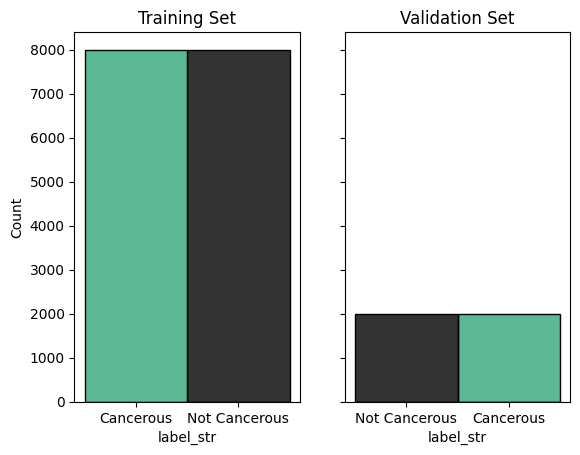

In [15]:
fig, ax = plt.subplots(1,2, sharey = True)

sns.histplot(y_train, x = 'label_str', hue = 'label_str', palette = class_cmap, alpha = 0.8, ax = ax[0])
ax[0].set_title('Training Set')
ax[0].get_legend().remove()
sns.histplot(y_val, x = 'label_str', hue = 'label_str', palette = class_cmap, alpha = 0.8, ax = ax[1])
ax[1].set_title('Validation Set')
ax[1].get_legend().remove()
plt.show()

Now, let's plot a few more slides and their labels along with the 32 x 32 rectangle that was used to determine the label.

Recall:

Each slide patch was given a 1 if any cancer tissue was found in the center 32 x 32 pixels of each image.

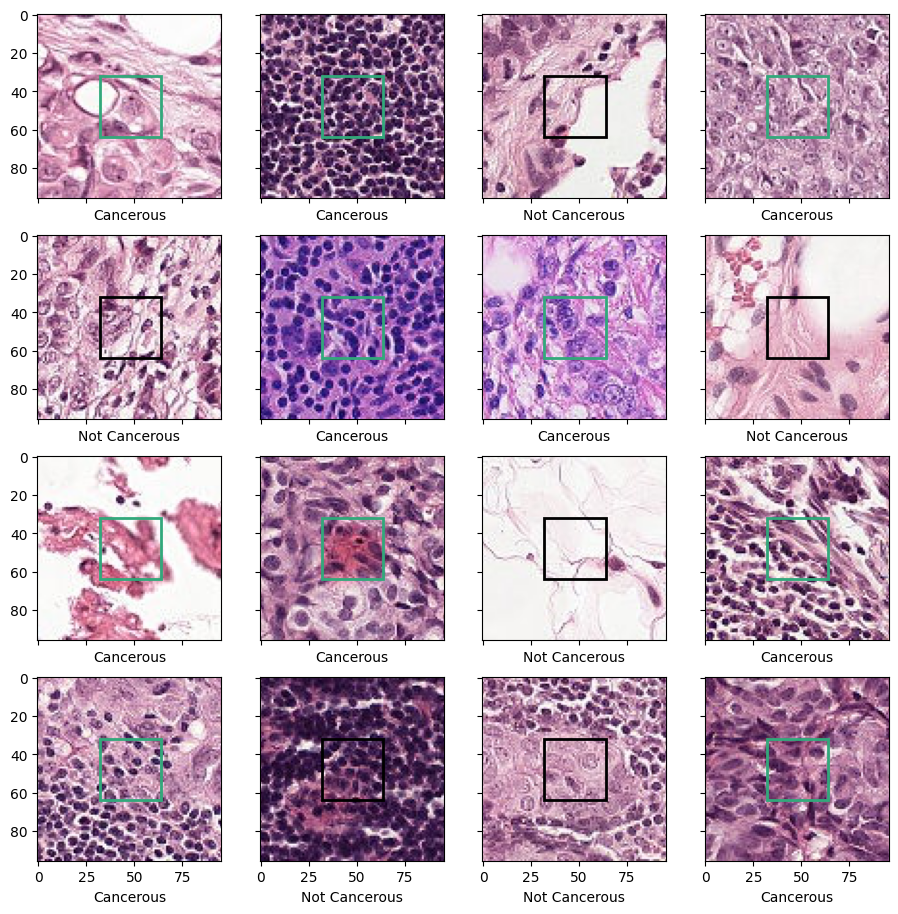

In [16]:
fig, ax = plt.subplots(4, 4, figsize = (11, 11), sharex = True, sharey = True)
for i in range(16):
    label = y_train.label.to_numpy()[i]
    
    ax[i//4, i%4].imshow(Image.fromarray(X_train[i].astype(np.uint8))) # PIL requires uint8.
    # Create rectangle for center 32 x 32 pixels to show cancer detection label.
    cancer_rect = patches.Rectangle((32, 32), 32, 32, linewidth = 2, facecolor = 'none',
                                    edgecolor = class_cmap['Cancerous'] if label == 1 else class_cmap['Not Cancerous'])
    ax[i%4, i//4].add_patch(cancer_rect)
    ax[i%4, i//4].set_xlabel(y_train.label_str.to_numpy()[i])
plt.show()

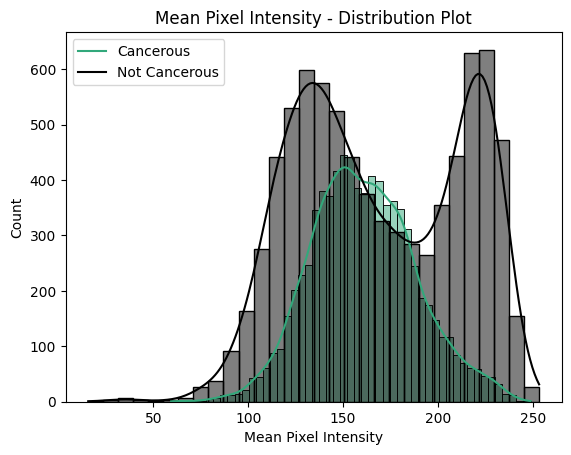

In [17]:
# Find the mean pixel intensity of each slide (down to one value along all axes).
mean_intensity = X_train.mean(axis = 1).mean(axis = 1).mean(axis = 1)
# Create a mask of only the cancerous slides.
mask_cancer = y_train.label.where(y_train.label == 1) == y_train.label.mask(~y_train.label == 1)
# Plot the distribution of the mean intensities of both cancerous and non-cancerous.
#   Cancer
sns.histplot(mean_intensity[mask_cancer], kde = True, color = class_cmap['Cancerous'])
#   Not Cancer
sns.histplot(mean_intensity[~mask_cancer], kde = True, color = class_cmap['Not Cancerous'])
plt.title('Mean Pixel Intensity - Distribution Plot')
plt.xlabel('Mean Pixel Intensity')
plt.legend(['Cancerous', 'Not Cancerous'])
plt.show()

Interestingly we do see a difference in distributions between the two classes.

- Non-cancerous slides have a bimodal distribution.
    - The right peak shows a mean value across all channels that is close to 255. This indicates slides that are majority white. Since there isn't a lot of overlap here with slides that are labeled as cancerous, that means there is either a sampling bias or a possible correlation between these values and our target variable.
    - The left peak indicates slides that are slightly darker.
- Cancerous slides have a mostly normal distribution centered around ~160.

What happens if we do the same plot, but separate the color channels?

RGB Mean Pixel Intensities:

In [18]:
mean_intensity_rgb = X_train.mean(axis = 1).mean(axis = 1)
print(mean_intensity_rgb.shape)
print(mean_intensity_rgb[0])

(16000, 3)
[215.34613715 176.27940538 197.73177083]


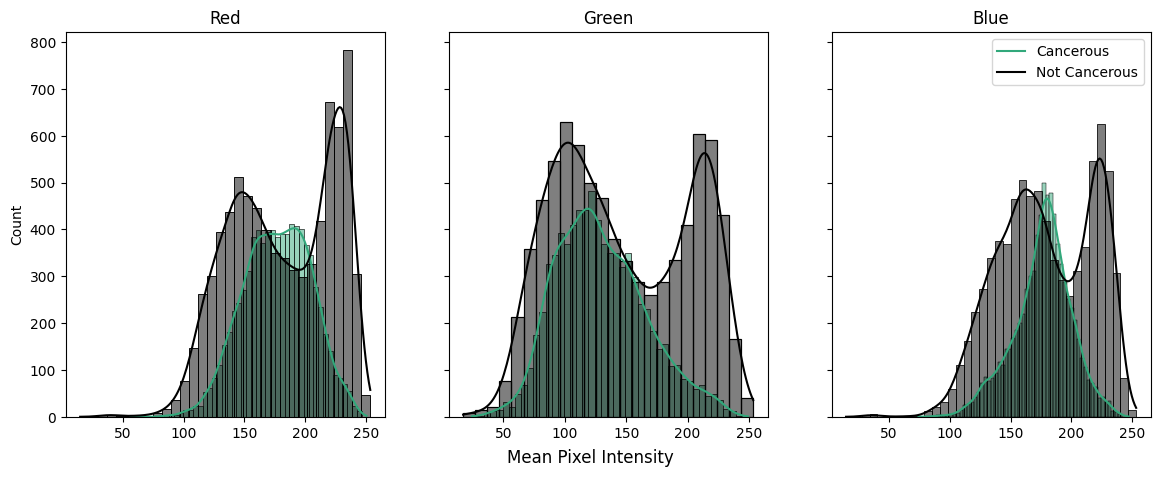

In [19]:
# Plot the distribution of the mean intensities of individual channels in both cancerous and non-cancerous.
fig, ax = plt.subplots(1, 3, figsize = (14, 5), sharey = True)
rgb_dict = {0:'Red', 1:'Green', 2:'Blue'}
for i in range(3):
    # Cancer
    sns.histplot(mean_intensity_rgb[:,i][mask_cancer], kde = True, color = class_cmap['Cancerous'], ax = ax[i])
    # Not Cancer
    sns.histplot(mean_intensity_rgb[:,i][~mask_cancer], kde = True, color = class_cmap['Not Cancerous'], ax = ax[i])
    ax[i].set_title(f'{rgb_dict[i]}')
fig.supxlabel('Mean Pixel Intensity')
plt.legend(['Cancerous', 'Not Cancerous'])
plt.show()

- We still see that the non-cancerous slides have a bimodal distribution which make sense because a mostly white slide requires all channels to be close to 255.
- The green and blue channels show a close overlap between the two classes.

###### [Back to Table of Contents](#toc)

## 5. Models and Embedding <a name="models"></a>

---

### 5.1. Baseline Models <a name="baseline"></a>

It's always important to set a suitable baseline for comparison.

The first baseline model is simple, equal random chance at selecting any of the classes.

In [20]:
mod_rand_baseline = 1 / len(y_train.label.unique()) # 1/2
print('Random Baseline AUC:', mod_rand_baseline)

Random Baseline AUC: 0.5


The next option is taking the most frequent class in the dataset and always predict that class.

Here we can take the most frequent class in the full training set (before balancing).

*Note: The y predictions will be submitted to Kaggle to receive the accuracy score and posted here and in the results section.*

In [21]:
train_labels.label.value_counts(sort = True)

label
0    130908
1     89117
Name: count, dtype: int64

In [22]:
most_freq_cat = train_labels.label.value_counts(sort = True).index[0]
mod_freq_array = np.full(shape = len(files_test), fill_value = most_freq_cat)

y_pred_freq_baseline = pd.DataFrame(files_test, columns = ['id']).map(lambda x: x.replace('.tif', ''))
y_pred_freq_baseline['label'] = mod_freq_array
y_pred_freq_baseline.to_csv(current_wdir + f'/Models/Frequency_Baseline/X_test_Submission_Freq_Baseline.csv', index = False)
display(y_pred_freq_baseline)

mod_freq_baseline = 0.5
print('Most Frequent Category Baseline AUC Score:', mod_freq_baseline)

,id,label
0,fd0a060ef9c30c9a83f6b4bfb568db74b099154d,0
1,1f9ee06f06d329eb7902a2e03ab3835dd0484581,0
2,19709bec800f372d0b1d085da6933dd3ef108846,0
3,7a34fc34523063f13f0617f7518a0330f6187bd3,0
4,93be720ca2b95fe2126cf2e1ed752bd759e9b0ed,0
...,...,...
57453,2581931c6ef068f105a872f2c5500275fc678242,0
57454,11b250a664d09ab59fd2afbdb2f8d786763b185d,0
57455,18a6030935ec1ef1ce486ec51bc95abb4008fbf1,0
57456,f541404e501e23a0188c852eb37eac94053cfdc0,0


Most Frequent Category Baseline AUC Score: 0.5


KNN as a Baseline

In [23]:
from sklearn.neighbors import KNeighborsClassifier
# TODO: Implement KNN discriminant plot from sklearn.
mod_knn = KNeighborsClassifier(n_neighbors = 2, weights = 'distance', algorithm = 'brute', p = 2)
mod_knn.fit(normalize_pixels(flat_stack(X_train)), y_train.label)

y_pred_proba = mod_knn.predict_proba(normalize_pixels(flat_stack(X_val)))
fpr, tpr, threshold = roc_curve(y_val.label, y_pred_proba[:, 1])
auc_score_knn = auc(fpr, tpr)
print('KNN Baseline AUC Score:', auc_score_knn)

KNN Baseline AUC Score: 0.611485


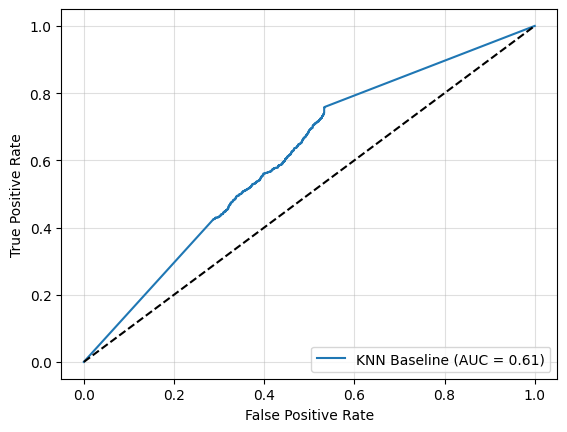

In [24]:
disp = RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = auc_score_knn, estimator_name = 'KNN Baseline')
disp.plot()
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'k--')
plt.grid(alpha = 0.4)
plt.show()

###### [Back to Table of Contents](#toc)

### 5.2. Model Helper Functions <a name="helper"></a>

Here I have created a few functions to help visualize the training process, tracking and plotting the training and validation metric and loss.

In [25]:
def set_region_overlay(model_history_df, x_offset):
    x_mid = ((model_history_df.index.stop-1) + model_history_df.val_loss.idxmin()) / 2
    plt.text(x = x_mid - x_offset,
             y = (plt.ylim()[0] + plt.ylim()[1]) / 2,
             s = 'Early Stop',
             rotation = 'horizontal',
             weight = 'extra bold',
             fontsize = 'large',
             antialiased = True,
             alpha = 1,
             c = 'white',
             bbox = dict(facecolor = 'black', edgecolor = 'black', boxstyle = 'round', alpha = 0.5))
    return None

def plot_TF_training_history(model_history_df):

    # Find all epochs that callback ReduceLROnPlateau() occurred.
    lr_change = model_history_df.learning_rate.shift(-1) != model_history_df.learning_rate

    # Create color map and lines style map for train/val
    plot_maps = {'cmap': {'accuracy': '#653096',
                        'loss': '#653096',
                        'val_accuracy': '#004a54',
                        'val_loss': '#004a54'},
                'dashmap': {'accuracy': '',
                            'loss': (2,1),
                            'val_accuracy': '',
                            'val_loss': (2,1)}}

    # Plot
    fig, ax = plt.subplots(figsize = (10,6))
    ax = sns.lineplot(model_history_df.drop(columns = ['learning_rate']).iloc[1:], palette = plot_maps['cmap'], dashes = plot_maps['dashmap'])
    ax.set_xlabel('Epoch')

    # Create secondary x-axis for Learning Rate changes.
    sec_ax = ax.secondary_xaxis('top')
    sec_ax.set_xticks(model_history_df[lr_change].index[:-1])
    sec_ax.set_xticklabels([f'{x:.1e}' for x in model_history_df[lr_change].learning_rate[1:]])
    sec_ax.tick_params(axis = 'x', which = 'major', labelsize = 7)
    sec_ax.set_xlabel('Learning Rate Reductions')

    # Create vertical line for each LR change.
    for epoch in (model_history_df[lr_change].index[:-1]):
        plt.axvline(x = epoch, c = '#d439ad', ls = (0, (5,5)))
    # Create lines for best epoch/val_loss.
    plt.axvline(x = (model_history_df.val_loss.idxmin()), c = '#f54260', ls = (0, (3,1,1,1)))
    plt.axhline(y = (model_history_df.val_loss.min()), c = '#f54260', alpha = 0.3, ls = (0, (3,1,1,1)))
    # Grey out epochs after early stop.
    plt.axvspan(model_history_df.val_loss.idxmin(), model_history_df.index.stop-1, facecolor = 'black', alpha = 0.25)
    plt.margins(x = 0)
    set_region_overlay(model_history_df, 5)

    plt.legend()
    plt.show()
    return None

###### [Back to Table of Contents](#toc)

### 5.3. Deep Learning <a name="deep"></a>

### 5.3.1. Shallow Feed Forward Network (FNN) <a name="fnn"></a>

Another quick pseudo-baseline model.

In [26]:
mod_fnn = tf.keras.Sequential()

mod_fnn.add(tf.keras.Input(shape = X_train[0].shape, name = 'Image Array'))
mod_fnn.add(tf.keras.layers.Flatten())
mod_fnn.add(tf.keras.layers.Dense(1024, activation = tf.keras.activations.relu))
mod_fnn.add(tf.keras.layers.Dropout(0.1))
mod_fnn.add(tf.keras.layers.Dense(512, activation = tf.keras.activations.relu))
mod_fnn.add(tf.keras.layers.Dropout(0.1))

mod_fnn.add(tf.keras.layers.Dense(1, name = 'Predictions'))

mod_fnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 27648)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    28,312,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Predictions (Dense)             │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,837,889 (110.01 MB)

 Trainable params: 28,837,889 (110.01 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
loss_fx = tf.keras.losses.BinaryCrossentropy(from_logits = True)
optimizer_param = tf.keras.optimizers.Adam(learning_rate = 0.01)
val_freq = 1
n_epochs = 150
# Callbacks to use:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 25, verbose = 1, restore_best_weights = True)
reduce_lr_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', 
                                                         factor = 0.5,
                                                         patience = 5,
                                                         cooldown = 8,
                                                         min_lr = 0.0001,
                                                         verbose = 1)

In [28]:
# mod_fnn.compile(optimizer = optimizer_param, loss = loss_fx, metrics = ['accuracy'])

# mod_tf_seq = mod_fnn.fit(
#     x = normalize_pixels(X_train),
#     y = y_train.label.to_numpy(),
#     batch_size = None,
#     epochs = n_epochs,
#     verbose = "auto",
#     callbacks = [early_stop, reduce_lr_plateau],
#     validation_split = 0.0,
#     validation_data = (normalize_pixels(X_val), y_val.label.to_numpy()),
#     shuffle = True,
#     class_weight = None,
#     sample_weight = None,
#     initial_epoch = 0,
#     steps_per_epoch = None,
#     validation_steps = None,
#     validation_batch_size = None,
#     validation_freq = val_freq)

CNN

Things to try:
- Remove Padding
- One more Conv2D + Pool
- Avg Pool
- Batch normalization
    - After activation
    - Before activation
    - Adjust Hyperparameters

In [29]:
mod_cnn = tf.keras.models.Sequential()
mod_cnn.add(tf.keras.Input(shape = (96,96,3), name = 'Image Array'))
mod_cnn.add(tf.keras.layers.Conv2D(16, kernel_size = (3,3), activation = 'relu', padding = 'same'))
#mod_cnn.add(tf.keras.layers.BatchNormalization(momentum = 0.1, epsilon = 0.00001))
mod_cnn.add(tf.keras.layers.Conv2D(16, kernel_size = (3,3), activation = 'relu', padding = 'same'))
#mod_cnn.add(tf.keras.layers.BatchNormalization(momentum = 0.1, epsilon = 0.00001))
mod_cnn.add(tf.keras.layers.MaxPooling2D((2,2), strides = 2))

mod_cnn.add(tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
#mod_cnn.add(tf.keras.layers.BatchNormalization(momentum = 0.1, epsilon = 0.00001))
mod_cnn.add(tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
#mod_cnn.add(tf.keras.layers.BatchNormalization(momentum = 0.1, epsilon = 0.00001))
mod_cnn.add(tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
#mod_cnn.add(tf.keras.layers.BatchNormalization(momentum = 0.1, epsilon = 0.00001))
mod_cnn.add(tf.keras.layers.MaxPooling2D((2,2), strides = 2))

mod_cnn.add(tf.keras.layers.Flatten())
#mod_cnn.add(tf.keras.layers.BatchNormalization(momentum = 0.1, epsilon = 0.00001))
mod_cnn.add(tf.keras.layers.Dense(1024, activation = 'relu'))
#mod_cnn.add(tf.keras.layers.BatchNormalization(momentum = 0.1, epsilon = 0.00001))
mod_cnn.add(tf.keras.layers.Dropout(0.5))
mod_cnn.add(tf.keras.layers.Dense(1024, activation = 'relu'))
#mod_cnn.add(tf.keras.layers.BatchNormalization(momentum = 0.1, epsilon = 0.00001))
mod_cnn.add(tf.keras.layers.Dropout(0.5))
mod_cnn.add(tf.keras.layers.Dense(1, name = 'Predictions'))
mod_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 96, 96, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │    18,875,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Predictions (Dense)             │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,951,921 (76.11 MB)

 Trainable params: 19,951,921 (76.11 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
loss_fx = tf.keras.losses.BinaryCrossentropy(from_logits = True) # Integer labels.
optimizer_param = 'sgd'
val_freq = 1
n_epochs = 300
# Callbacks to use:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1, restore_best_weights = True)
reduce_lr_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', 
                                                         factor = 0.5,
                                                         patience = 4,
                                                         cooldown = 5,
                                                         min_lr = 0.0001,
                                                         verbose = 1)

In [31]:
mod_cnn.compile(loss = loss_fx,
                optimizer = optimizer_param,
                metrics = ['accuracy'])

mod_cnn_hist = mod_cnn.fit(normalize_pixels(X_train), y_train.label.to_numpy(),
                           batch_size = None,
                           epochs = n_epochs,
                           verbose = "auto",
                           callbacks = [early_stop, reduce_lr_plateau],
                           validation_split = 0.0,
                           validation_data = (normalize_pixels(X_val), y_val.label.to_numpy()),
                           shuffle = True,
                           class_weight = None,
                           sample_weight = None,
                           initial_epoch = 0,
                           steps_per_epoch = None,
                           validation_steps = None,
                           validation_batch_size = None,
                           validation_freq = val_freq)

Epoch 1/300
500/500 ━━━━━━━━━━━━━━━━━━━━ 68s 135ms/step - accuracy: 0.5072 - loss: 0.6819 - val_accuracy: 0.6380 - val_loss: 0.5464 - learning_rate: 0.0100
Epoch 2/300
500/500 ━━━━━━━━━━━━━━━━━━━━ 69s 137ms/step - accuracy: 0.6798 - loss: 0.5869 - val_accuracy: 0.6967 - val_loss: 0.5410 - learning_rate: 0.0100
Epoch 3/300
500/500 ━━━━━━━━━━━━━━━━━━━━ 70s 140ms/step - accuracy: 0.7364 - loss: 0.5210 - val_accuracy: 0.7660 - val_loss: 0.4711 - learning_rate: 0.0100
Epoch 4/300
500/500 ━━━━━━━━━━━━━━━━━━━━ 70s 140ms/step - accuracy: 0.7583 - loss: 0.4981 - val_accuracy: 0.7670 - val_loss: 0.4677 - learning_rate: 0.0100
Epoch 5/300
500/500 ━━━━━━━━━━━━━━━━━━━━ 71s 142ms/step - accuracy: 0.7733 - loss: 0.4753 - val_accuracy: 0.7950 - val_loss: 0.4711 - learning_rate: 0.0100
Epoch 6/300
500/500 ━━━━━━━━━━━━━━━━━━━━ 68s 135ms/step - accuracy: 0.7766 - loss: 0.4710 - val_accuracy: 0.7997 - val_loss: 0.4248 - learning_rate: 0.0100
Epoch 7/300
500/500 ━━━━━━━━━━━━━━━━━━━━ 67s 134ms/step - accura

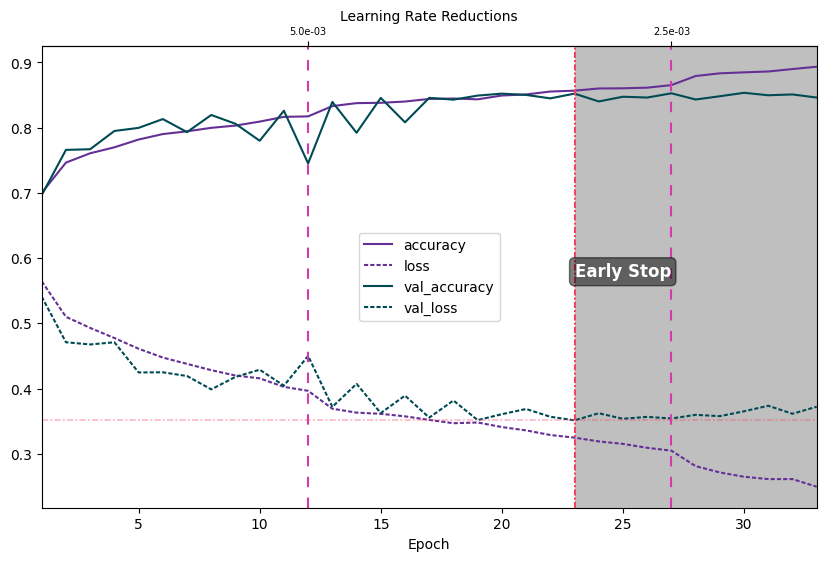

In [32]:
# Create dataframe of model fit history.
mod_cnn_hist_df = pd.DataFrame().from_dict(mod_cnn_hist.history, orient = 'columns')

plot_TF_training_history(mod_cnn_hist_df)

###### [Back to Table of Contents](#toc)

## 6. Results <a name="results"></a>

---

In [ ]:
# Highlight the best model's test results green at each proportion.
def max_value_highlight(df):
    max_test_rows = df.max()
    is_max = (df == max_test_rows)
    
    return ['background-color:green' if v else '' for v in is_max]

# Highlight the top two results in each column blue so that 2nd place is in blue after .apply().
def highlight_top_two(df):
    # Sort values
    test_rows = df
    sorted_df = test_rows.sort_values(ascending = False)
    top_two = sorted_df.iloc[: 2]
    # Mask
    is_top_two = df.isin(top_two)

    return ['background-color: blue' if v else '' for v in is_top_two]

To evaluate the test set the .csv files must be submitted to Kaggle. Each model's predictions were saved above and manually submitted. Below you can find a screenshot of all the results.

<img src="https://github.com/chill0121/Kaggle_Projects/blob/main/NLP_Disaster_Tweets/Models/Kaggle_Results.png?raw=true" alt="results" width="1000"/>

In [ ]:
# # Kaggle Submission Scores for Test Set.
# results_test = {'Random_Baseline' : mod_rand_baseline,
#                 'Frequent_Baseline' : mod_freq_baseline,
#                 'RNN' : 0.73000,
#                 'LSTM' : 0.77903,
#                 'GRU' : 0.73582}

# results_test_df = pd.DataFrame().from_dict(results_test, orient = 'index', columns = ['F1-Score'])
# results_test_df.index.name = 'Model'

# results_test_df.style.apply(highlight_top_two).apply(max_value_highlight)

,F1-Score
Model,
Random_Baseline,0.500000
Frequent_Baseline,0.570330
RNN,0.730000
LSTM,0.779030
GRU,0.735820


The best model's score is highlighted in green and the 2nd best is in blue.

Discussions can be found in the conclusion section.

###### [Back to Table of Contents](#toc)

## 7. Conclusion - Kaggle Submission Test Set <a name="conclusion"></a>

---



### 7.1. Possible Areas for Improvement <a name="improvements"></a>



###### [Back to Table of Contents](#toc)

## Appendix A - Online References: <a name="appendixa"></a>

Resources that helped along the way in no particular order.

1. 

 Exported to HTML via command line using:

- `jupyter nbconvert Cancer_Detection_Histopathology.ipynb --to html`
- `jupyter nbconvert Cancer_Detection_Histopathology.ipynb --to html --HTMLExporter.theme=dark`

###### [Back to Table of Contents](#toc)